## Anomaly Detection

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


- Task: Find Images which are not normal but show some kind of abnormality 
- Dataset: Cropped and Resized Images
- Preprocessing for VGG-16

Sources:
- https://arxiv.org/abs/1409.1556

Generator
- Scaling of data and reading in batches on the fly

Model
- Two conv layers followed by Pooling layer with max pooling
- 32 Filters in first block, 64 in second, 128 in third
- Kernel Size 3,3
- Activation Relu
- Kernel Initializer: https://arxiv.org/abs/1502.01852
- padding = same

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from keras.models import Sequential
from keras_preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Anomaly Detection/train_binary.csv')

In [5]:
df.shape

(6060, 2)

In [6]:
df.head()

,filename,normal
0,c24a1b14d253.jpg,0
1,9ee905a41651.jpg,0
2,3f58d128caf6.jpg,0
3,4ce6599e7b20.jpg,0
4,0def470360e4.jpg,0


In [7]:
df.dtypes

filename    object
normal       int64
dtype: object

In [8]:
# Keras Gen needs str for Classes
df.normal = df.normal.astype('str')

In [9]:
# check vales
df.normal.value_counts()

1    3150
0    2910
Name: normal, dtype: int64

In [10]:
# As data is ordered in dataframe after augmentation, shuffle it
from sklearn.utils import shuffle 
df = shuffle(df)

In [11]:
# Directory
indir = '/content/drive/MyDrive/Anomaly Detection/train'

In [12]:
datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split = 0.25)

In [13]:
train_gen = datagen.flow_from_dataframe(dataframe = df, 
                                        directory = indir, 
                                        x_col = "filename", 
                                        y_col = 'normal',
                                        batch_size = 100, 
                                        seed = 2, 
                                        shuffle = True, 
                                        class_mode = "binary", 
                                        target_size = (300,300),
                                        subset='training')

Found 4545 validated image filenames belonging to 2 classes.


In [14]:
val_gen = datagen.flow_from_dataframe(dataframe = df, 
                                      directory = indir, 
                                      x_col = "filename", 
                                      y_col = 'normal',
                                      batch_size = 100, 
                                      seed = 2, 
                                      shuffle = True, 
                                      class_mode = "binary", 
                                      target_size = (300,300),
                                      subset='validation')

Found 1515 validated image filenames belonging to 2 classes.


In [15]:
imgs, labels = next(train_gen)

In [16]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


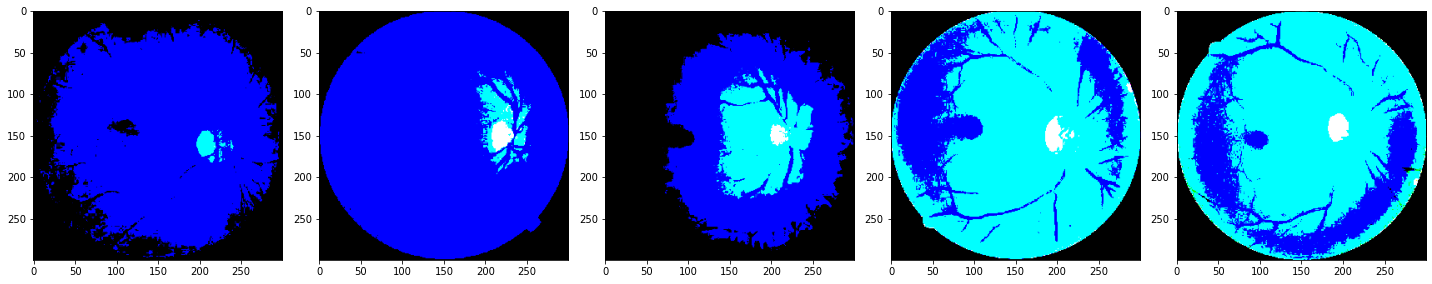

In [17]:
plotImages(imgs)

In [18]:
early_stopping = EarlyStopping(patience=5)

In [19]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(300,300,3)))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(1, activation='sigmoid'))


In [20]:
opt = SGD(lr=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [21]:
step_size_train = train_gen.n//train_gen.batch_size
step_size_val = val_gen.n//val_gen.batch_size

In [22]:
history = model.fit(x=train_gen, validation_data=val_gen, steps_per_epoch=step_size_train, 
          validation_steps=step_size_val, epochs=20, callbacks=[early_stopping],verbose=2)

Epoch 1/20
45/45 - 74s - loss: nan - accuracy: 0.4884 - val_loss: nan - val_accuracy: 0.4707
Epoch 2/20
45/45 - 44s - loss: nan - accuracy: 0.4829 - val_loss: nan - val_accuracy: 0.4687
Epoch 3/20
45/45 - 45s - loss: nan - accuracy: 0.4875 - val_loss: nan - val_accuracy: 0.4700
Epoch 4/20
45/45 - 46s - loss: nan - accuracy: 0.4846 - val_loss: nan - val_accuracy: 0.4687
Epoch 5/20
45/45 - 44s - loss: nan - accuracy: 0.4821 - val_loss: nan - val_accuracy: 0.4687


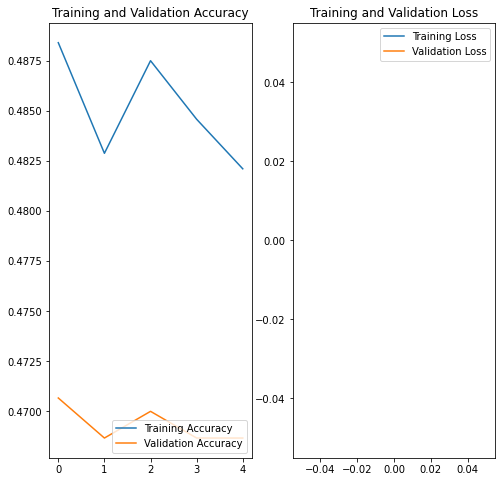

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(5)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()